# Q.6 Exploring Maximum a Posteriori (MAP) Estimation

In [3]:
#All imports

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider

In [4]:
from scipy import stats

In [5]:
#########################################
# Generate 100 data points of noisy sinusoidal data
#########################################

def generate_sinusoidal_data(n_points=100, noise_var=0.1):
    x = np.linspace(0, 1, n_points)
    noise = np.random.normal(0, np.sqrt(noise_var), n_points)
    t = np.sin(2 * np.pi * x) + noise
    return x, t

# Generate dataset
X, T = generate_sinusoidal_data(100, 0.1)

In [6]:
#########################################
# Gaussian basis functions and design matrix
#########################################
M = 20  # 20th-order model-> 21 basis functions (including bias)
mu = np.linspace(0, 1, M)

def gaussian_basis_functions(x, mu, s= 0.1):
    s = (np.max(x) - np.min(x)) / M * 2
    s = np.where(s == 0, 1e-8, s)
    return np.exp(-0.5 * ((x[:, np.newaxis] - mu[np.newaxis, :]) / s) ** 2)

def create_design_matrix(x, mu, include_bias=True):
    phi = gaussian_basis_functions(x, mu)
    if include_bias:
        phi = np.hstack([np.ones((x.shape[0], 1)), phi])
    return phi

Phi = create_design_matrix(X, mu)
N, M_plus_1 = Phi.shape

In [7]:
#########################################
# Update the statistics of posterior density
#########################################

# Initialize parameters for standard normal prior
alpha = 1.0  # prior precision
beta = 1.0 / 0.1  # noise precision (inverse variance)

# Initialise the parameters for standard normal priors
S0_inv = alpha * np.eye(M_plus_1)
m0 = np.zeros(M_plus_1)

In [8]:
#########################################
# Sequential Bayesian update
#########################################

def sequential_bayesian_update(phi_n, t_n, S_prev_inv, m_prev):
    S_new_inv = S_prev_inv + beta * np.outer(phi_n, phi_n)
    S_new = np.linalg.inv(S_new_inv)
    m_new = S_new @ (S_prev_inv @ m_prev + beta * t_n * phi_n)
    return S_new_inv, S_new, m_new

S_inv_history = [S0_inv.copy()]
S_history = [np.linalg.inv(S0_inv)]
m_history = [m0.copy()]
S_current_inv = S0_inv.copy()
m_current = m0.copy()

for i in range(N):
    phi_n = Phi[i, :]
    t_n = T[i]
    S_current_inv, S_current, m_current = sequential_bayesian_update(phi_n, t_n, S_current_inv, m_current)
    S_inv_history.append(S_current_inv.copy())
    S_history.append(S_current.copy())
    m_history.append(m_current.copy())

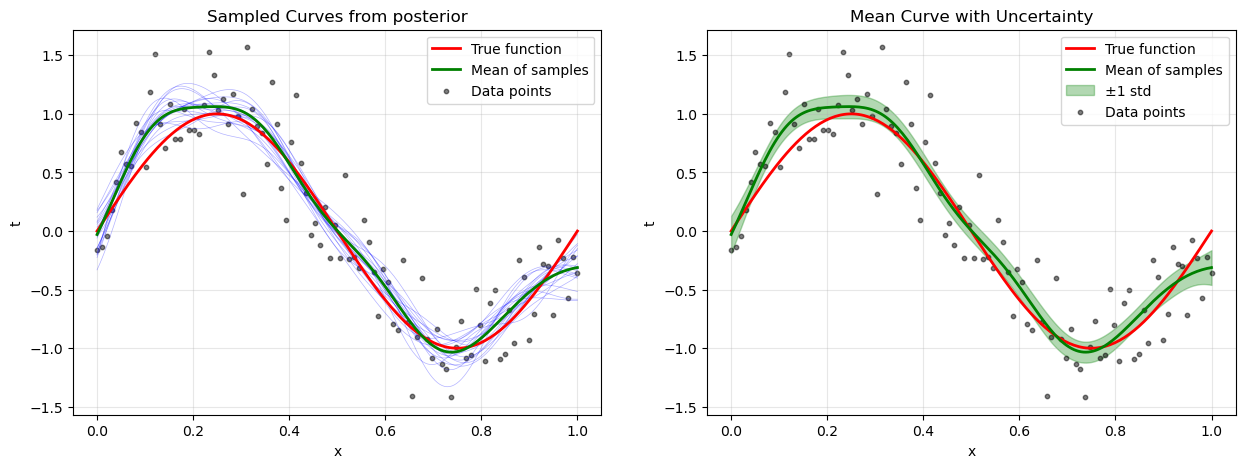

In [9]:
#########################################
# Sampling weight vector from posterior distribution
#########################################

def sample_from_posterior(m, S, n_samples=1):
    return np.random.multivariate_normal(m, S, n_samples)

def predict_with_weights(w, x_test, mu):
    phi_test = create_design_matrix(x_test, mu)
    return phi_test @ w

x_test = np.linspace(0, 1, 200)
true_function = np.sin(2 * np.pi * x_test)
final_m = m_history[-1]
final_S = S_history[-1]
n_curve_samples = 100

sampled_curves = []
for i in range(n_curve_samples):
    w_sample = sample_from_posterior(final_m, final_S, 1)[0]
    y_pred = predict_with_weights(w_sample, x_test, mu)
    sampled_curves.append(y_pred)

sampled_curves = np.array(sampled_curves)
mean_curve = np.mean(sampled_curves, axis=0)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i in range(20):
    plt.plot(x_test, sampled_curves[i], 'b-', alpha=0.3, linewidth=0.5)
plt.plot(x_test, true_function, 'r-', linewidth=2, label='True function')
plt.plot(x_test, mean_curve, 'g-', linewidth=2, label='Mean of samples')
plt.scatter(X, T, color='black', s=10, alpha=0.5, label='Data points')
plt.title('Sampled Curves from posterior')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(x_test, true_function, 'r-', linewidth=2, label='True function')
plt.plot(x_test, mean_curve, 'g-', linewidth=2, label='Mean of samples')
plt.fill_between(x_test,
                mean_curve - np.std(sampled_curves, axis=0),
                mean_curve + np.std(sampled_curves, axis=0),
                alpha=0.3, color='green', label='±1 std')
plt.scatter(X, T, c='black', s=10, alpha=0.5, label='Data points')
plt.title('Mean Curve with Uncertainty')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()
plt.grid(True, alpha=0.3)

In [10]:
#########################################
# Predictive distribution analysis
#########################################

def predictive_distribution(x_star, phi_star, m, S, beta):
    mean = phi_star @ m
    var = 1 / beta + phi_star @ S @ phi_star.T
    return mean, var

x_star = 0.5
phi_star = create_design_matrix(np.array([x_star]), mu).flatten()
data_points_to_analyze = [10, 25, 50, 75, 100]

predictive_means = []
predictive_vars = []

for n_data in data_points_to_analyze:
    idx = min(n_data, len(m_history) - 1)
    m_n = m_history[idx]
    S_n = S_history[idx]
    mean_pred, var_pred = predictive_distribution(x_star, phi_star, m_n, S_n, beta)
    predictive_means.append(mean_pred)
    predictive_vars.append(var_pred)

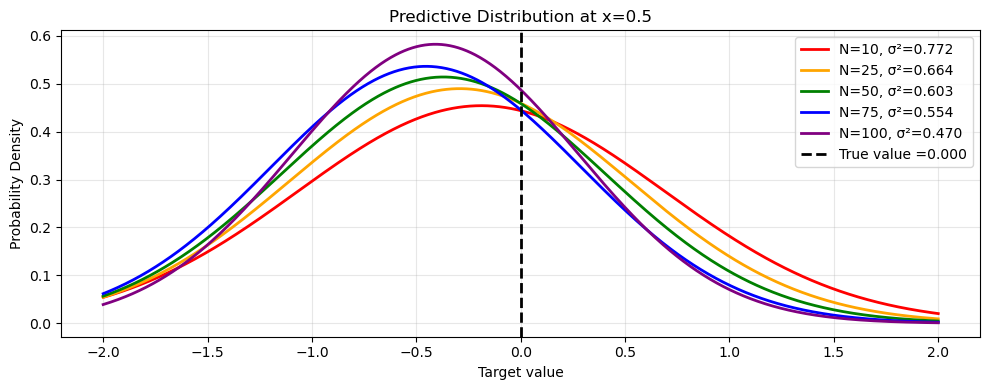

In [11]:
plt.figure(figsize=(10, 4))
x_vals = np.linspace(-2, 2, 1000)
colors = ['red', 'orange', 'green', 'blue', 'purple']

for i, (n_data, mean, var) in enumerate(zip(data_points_to_analyze, predictive_means, predictive_vars)):
    std = np.sqrt(var)
    pdf = stats.norm.pdf(x_vals, mean, std)
    plt.plot(x_vals, pdf, color=colors[i], linewidth=2, label=f'N={n_data}, σ²={var:.3f}')

true_value_at_star = np.sin(2 * np.pi * x_star)
plt.axvline(true_value_at_star, color='black', linestyle='--', linewidth=2, label=f'True value ={true_value_at_star:.3f}')
plt.title(f'Predictive Distribution at x={x_star}')
plt.xlabel('Target value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


1. **Uncertainty reduces with more data**  
   As training size increases (N=10 to N=100), the predictive variance shrinks significantly, especially between N=10 and N=25, reflecting rapid early learning.

2. **Predictive accuracy improves**  
   The predictive mean aligns more closely with the true function value at `x = 0.5` as N increases, with the true value consistently moving closer to the mode of the distribution.

3. **Model confidence saturates at higher N**  
   Beyond N=75, additional data yields diminishing returns — the predictive distribution becomes only marginally narrower, indicating stabilized learning.


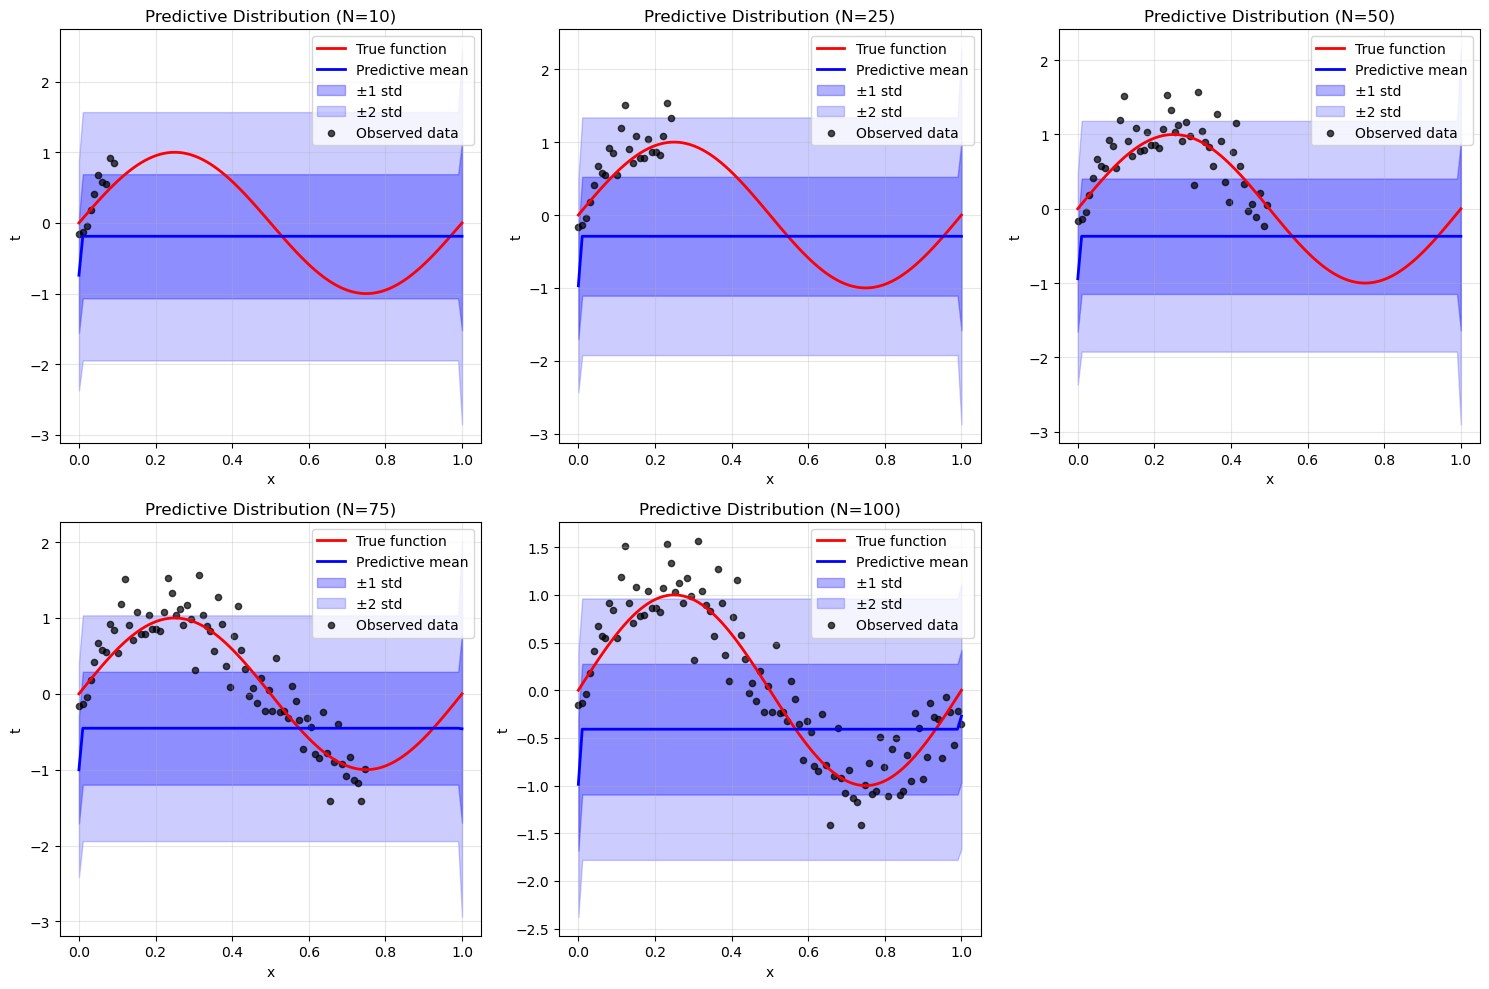

In [12]:
# Detailed analysis of predictive distributions across input space
plt.figure(figsize=(15, 10))

# Create a grid of test points
x_test_grid = np.linspace(0, 1, 100)

for subplot_idx, n_data in enumerate([10, 25, 50, 75, 100]):
    plt.subplot(2, 3, subplot_idx + 1)

    idx = min(n_data, len(m_history) - 1)
    m_n = m_history[idx]
    S_n = S_history[idx]

    # Compute predictive mean and variance for all test points
    pred_means = []
    pred_stds = []

    for x_val in x_test_grid:
        phi_test = create_design_matrix(np.array([x_val]), mu).flatten()
        mean_pred, var_pred = predictive_distribution(x_val, phi_test, m_n, S_n, beta)
        pred_means.append(mean_pred)
        pred_stds.append(np.sqrt(var_pred))

    pred_means = np.array(pred_means)
    pred_stds = np.array(pred_stds)

    # Plot true function
    plt.plot(x_test_grid, np.sin(2 * np.pi * x_test_grid), 'r-', linewidth=2, label='True function')

    # Plot predictive mean
    plt.plot(x_test_grid, pred_means, 'b-', linewidth=2, label='Predictive mean')

    # Plot uncertainty bounds
    plt.fill_between(x_test_grid,
                    pred_means - pred_stds,
                    pred_means + pred_stds,
                    alpha=0.3, color='blue', label='±1 std')

    plt.fill_between(x_test_grid,
                    pred_means - 2*pred_stds,
                    pred_means + 2*pred_stds,
                    alpha=0.2, color='blue', label='±2 std')

    # Plot observed data points
    if n_data < len(X):
        plt.scatter(X[:n_data], T[:n_data], c='black', s=20, alpha=0.7, label='Observed data')
    else:
        plt.scatter(X, T, c='black', s=20, alpha=0.7, label='Observed data')

    plt.title(f'Predictive Distribution (N={n_data})')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Observations from Predictive Distributions

1. **Uncertainty reduces with increasing data**  
   The shaded uncertainty bands (±1σ and ±2σ) are wide when only 10–25 points are used but become progressively narrower with 50, 75, and 100 data points — confirming that model confidence increases as more data becomes available.

2. **Better alignment with the true function**  
   With 75 and 100 training points, the predictive mean (blue line) closely follows the true sinusoidal function (red line), whereas with fewer points, it deviates more — especially in less observed regions like the middle and right.

3. **Uncertainty highest in data-sparse regions**  
   For smaller training sizes, variance is especially high where data is sparse (e.g., right end of plots for N=10, 25). As more points cover the input space, especially near \( x = 0.5 \) and beyond, uncertainty visibly drops.


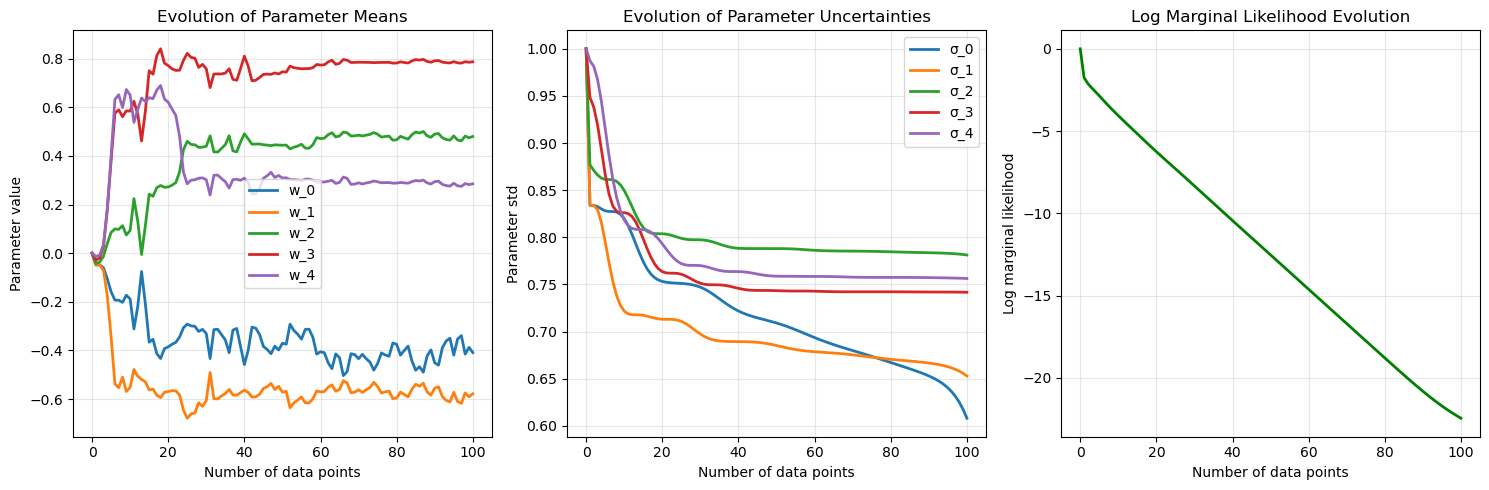

In [13]:
# Analysis of parameter evolution
plt.figure(figsize=(15, 5))

# Plot evolution of first few parameters
plt.subplot(1, 3, 1)
n_params_to_plot = min(5, M_plus_1)
for i in range(n_params_to_plot):
    param_evolution = [m[i] for m in m_history]
    plt.plot(range(len(param_evolution)), param_evolution,
             linewidth=2, label=f'w_{i}')
plt.title('Evolution of Parameter Means')
plt.xlabel('Number of data points')
plt.ylabel('Parameter value')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot evolution of parameter uncertainties (diagonal of covariance)
plt.subplot(1, 3, 2)
for i in range(n_params_to_plot):
    param_std_evolution = [np.sqrt(S[i, i]) for S in S_history]
    plt.plot(range(len(param_std_evolution)), param_std_evolution,
             linewidth=2, label=f'σ_{i}')
plt.title('Evolution of Parameter Uncertainties')
plt.xlabel('Number of data points')
plt.ylabel('Parameter std')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot log marginal likelihood evolution (model evidence)
plt.subplot(1, 3, 3)
log_marginal_likelihoods = []
for i in range(len(m_history)):
    if i == 0:
        log_ml = 0  # Prior
    else:
        # Approximate log marginal likelihood
        S_inv = S_inv_history[i]
        m = m_history[i]
        log_ml = -0.5 * (np.linalg.slogdet(S_inv)[1] - np.linalg.slogdet(S0_inv)[1])
    log_marginal_likelihoods.append(log_ml)

plt.plot(range(len(log_marginal_likelihoods)), log_marginal_likelihoods,
         'g-', linewidth=2)
plt.title('Log Marginal Likelihood Evolution')
plt.xlabel('Number of data points')
plt.ylabel('Log marginal likelihood')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Observations from Parameter Evolution

1. **Stabilization of parameter means with more data**  
   As training data increases, the mean estimates of parameters (w₀ to w₄) gradually stabilize, indicating convergence of the posterior toward true underlying weights.

2. **Reduction in parameter uncertainty**  
   The standard deviations of parameters (√diag(S)) decrease steadily with data size, showing increasing model confidence in the learned weights.

3. **Log marginal likelihood increases initially**  
   The log marginal likelihood (model evidence) grows rapidly at first, then saturates — implying that new data improves model fit early on, with diminishing returns as data becomes abundant.


**OBSERVATIONS**

1. As more data is observed, the MAP estimates of parameters converge, with their mean values stabilizing and uncertainty (standard deviation) reducing — indicating the model is learning more confidently.

2. The posterior distribution narrows significantly with increasing data, particularly in early stages, reflecting higher certainty in parameter values and less reliance on the prior.

3. With more training points, the MAP-based predictive mean closely tracks the true function, and the predictive uncertainty shrinks — especially in regions previously data-sparse.